In [1]:
import pandas as pd
import csv
import numpy as np
from numpy import mean, std
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy.stats import uniform
from sklearn.metrics import accuracy_score
from datetime import datetime as dt

## Importing and Cleaning Data

In [2]:
df = pd.read_csv('CC.tsv', header=0, sep="\t")

#### Dropping NAs

In [3]:
print("Data dimensions before dropping NAs = ", df.shape)
df = df.dropna()
print("Data dimensions after dropping NAs = ", df.shape)

Data dimensions before dropping NAs =  (7288181, 22)
Data dimensions after dropping NAs =  (6604676, 22)


#### Dropping irrelevant columns

In [4]:
irrelevant_columns = ['ID', 'Case Number', 'X Coordinate', 'Y Coordinate', 'Updated On', 'Latitude', 'Longitude', 'Location']
print("Irrelevant columns are: ", irrelevant_columns)
df = df.drop(columns=irrelevant_columns)

Irrelevant columns are:  ['ID', 'Case Number', 'X Coordinate', 'Y Coordinate', 'Updated On', 'Latitude', 'Longitude', 'Location']


#### Converting Date to datetime and obtaining Month, Day and Hour

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Month Name'] = pd.DatetimeIndex(df['Date']).month_name()
df['Day'] = pd.DatetimeIndex(df['Date']).day
print("Day 0 = Monday, Day 6 = Sunday")
df['Day Name'] = pd.DatetimeIndex(df['Date']).day_name()
df['Day of Week'] = pd.DatetimeIndex(df['Date']).dayofweek
df['Hour'] = pd.DatetimeIndex(df['Date']).hour
df = df.drop(columns=['Date'])

Day 0 = Monday, Day 6 = Sunday


#### Obtaining Community Area Names from a separate dataset

This is to help in Data Visualisation, where we can display the names of the Community Areas instead of merely their code. 

In [6]:
df_comm = pd.read_csv('Community Area Names.csv')
df = df.merge(df_comm, how='left', on='Community Area')
df = df[df.columns[:20]]

#### Correcting data types (e.g. category, int64)

In [7]:
old_dtypes = df.dtypes
print("Primary Type was left unchanged because we will be reclassifying the types later.")

df['Block'] = pd.factorize(df['Block'])[0]
df['IUCR'] = pd.factorize(df['IUCR'])[0]
df['Description'] = pd.factorize(df['Description'])[0]
df['Location Description'] = pd.factorize(df['Location Description'])[0]
df['FBI Code'] = pd.factorize(df['FBI Code'])[0]

df = df.astype({'Block': 'category', 'IUCR': 'category', 'Description': 'category', 'Location Description': 'category', 
                'FBI Code': 'category', 'Beat': 'category', 'District': 'category', 'Ward': 'category', 
                'Community Area': 'category', 'Year': 'category', 'Month': 'category', 'Day': 'category', 
                'Day of Week': 'category', 'Hour': 'category'})

new_dtypes = df.dtypes
compare = pd.concat([old_dtypes, new_dtypes], axis=1)
compare.columns = ["Old Data Types", "New Data Types"]
compare

Primary Type was left unchanged because we will be reclassifying the types later.


,Old Data Types,New Data Types
Block,object,category
IUCR,object,category
Primary Type,object,object
Description,object,category
Location Description,object,category
Arrest,bool,bool
Domestic,bool,bool
Beat,int64,category
District,float64,category
Ward,float64,category


## Data Visualisation

#### Most prevalent Primary Types

<AxesSubplot:xlabel='Number of Crimes', ylabel='Primary Type'>

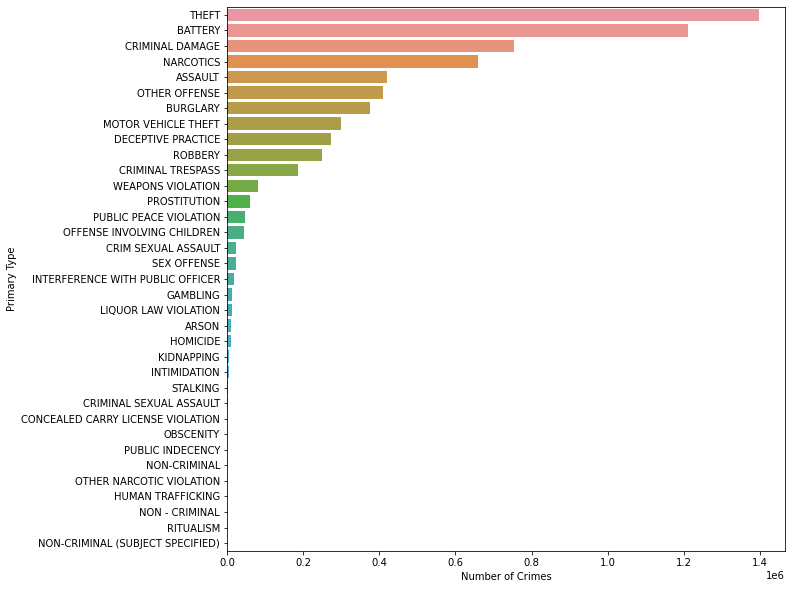

In [8]:
df_plot_pri = pd.DataFrame(df['Primary Type'].value_counts()).reset_index()
df_plot_pri.columns = ['Primary Type', 'Number of Crimes']

plt.figure(figsize=(10,10))
sns.barplot(y='Primary Type', x='Number of Crimes', data=df_plot_pri)

We can see that the Primary Types are rather imbalanced. The last 20 Primary Types have very much less counts than the top 15.

With that, we propose that the Primary Types be classified based on their similarity. For instance, Theft and Motor Vehicle Theft can be both classified under the Primary Type "Theft".

#### Classification

Theft: THEFT, MOTOR VEHICLE THEFT, DECEPTIVE PRACTICE, ROBBERY, BURGLARY, KIDNAPPING

Property: CRIMINAL DAMAGE, ARSON, CRIMINAL TRESPASS

Assault: ASSAULT, BATTERY, INTIMIDATION, HOMICIDE

Addiction: NARCOTICS, LIQUOR LAW VIOLATION, GAMBLING, OTHER NARCOTIC VIOLATION

Weapons: WEAPONS VIOLATION, CONCEALED CARRY LICENSE VIOLATION

Sexual: SEX OFFENCE, CRIMINAL SEXUAL ASSAULT, CRIM SEXUAL ASSAULT, OBSCENITY, PROSTITUTION, PUBLIC INDECENCY

Others: OTHER OFFENSE, INTERFERENCE WITH PUBLIC OFFICER, OFFENCE INVOLVING CHILDREN, STALKING, PUBLIC PEACE VIOLATION, HUMAN TRAFFICKING, NON-CRIMINAL, NON-CRIMINAL (SUBJECT SPECIFIED), NON - CRIMINAL, RITUALISM

In [9]:
df_grp = df.replace(['THEFT', 'MOTOR VEHICLE THEFT', 'DECEPTIVE PRACTICE', 'ROBBERY', 'BURGLARY', 'KIDNAPPING'], 'Theft')
df_grp = df_grp.replace(['CRIMINAL DAMAGE', 'ARSON', 'CRIMINAL TRESPASS'], 'Property')
df_grp = df_grp.replace(['ASSAULT', 'BATTERY', 'INTIMIDATION', 'HOMICIDE'], 'Assault')
df_grp = df_grp.replace(['NARCOTICS', 'LIQUOR LAW VIOLATION', 'GAMBLING', 'OTHER NARCOTIC VIOLATION'], 'Addiction')
df_grp = df_grp.replace(['WEAPONS VIOLATION', 'CONCEALED CARRY LICENSE VIOLATION'], 'Weapons')
df_grp = df_grp.replace(['SEX OFFENSE', 'CRIMINAL SEXUAL ASSAULT', 'CRIM SEXUAL ASSAULT', 'OBSCENITY', 'PROSTITUTION', 'PUBLIC INDECENCY'], 'Sexual')
df_grp = df_grp.replace(['OTHER OFFENSE', 'INTERFERENCE WITH PUBLIC OFFICER', 'OFFENSE INVOLVING CHILDREN', 'STALKING', 'PUBLIC PEACE VIOLATION', 'HUMAN TRAFFICKING', 'NON-CRIMINAL', 'NON - CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)', 'RITUALISM'], 'Others')

#### Most prevalent Primary Types after classification

<AxesSubplot:xlabel='Number of Crimes', ylabel='Primary Type'>

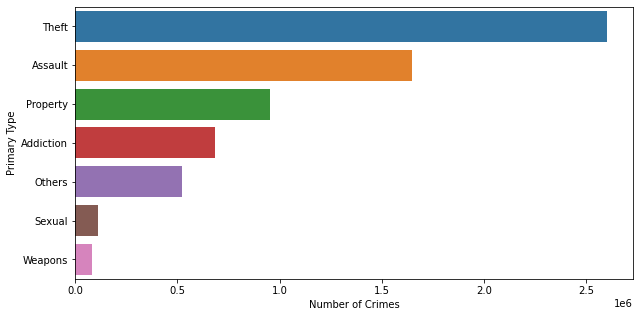

In [10]:
df_plot_grp = pd.DataFrame(df_grp['Primary Type'].value_counts()).reset_index()
df_plot_grp.columns = ['Primary Type', 'Number of Crimes']

plt.figure(figsize=(10,5))
sns.barplot(y='Primary Type', x='Number of Crimes', data=df_plot_grp)

#### Community Areas with the most crimes

<AxesSubplot:xlabel='Number of Crimes', ylabel='Community Area'>

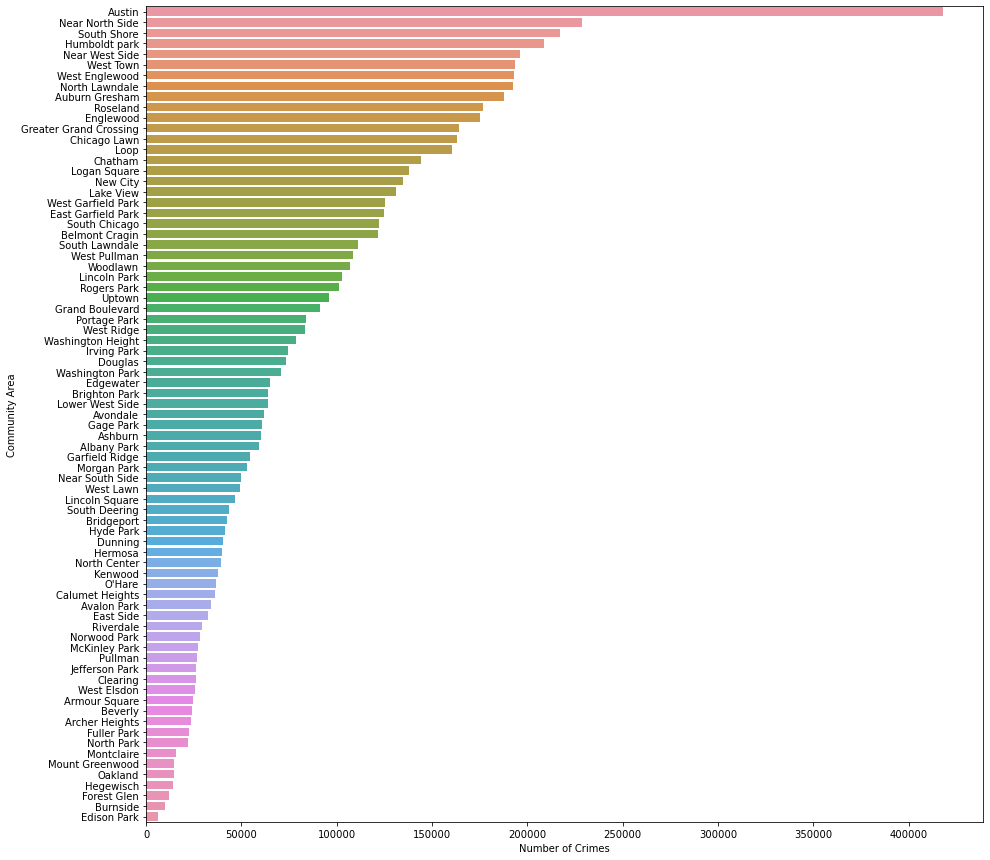

In [11]:
df_plot_comm = pd.DataFrame(df['Community Area Name'].value_counts()).reset_index()
df_plot_comm.columns = ['Community Area', 'Number of Crimes']

plt.figure(figsize=(15,15))
sns.barplot(y='Community Area', x='Number of Crimes', data=df_plot_comm)

Austin residents and police force might want to stay vigilant and prepared for crimes!

#### Trend of the number of crimes over the years

<AxesSubplot:xlabel='Year', ylabel='Number of Crimes'>

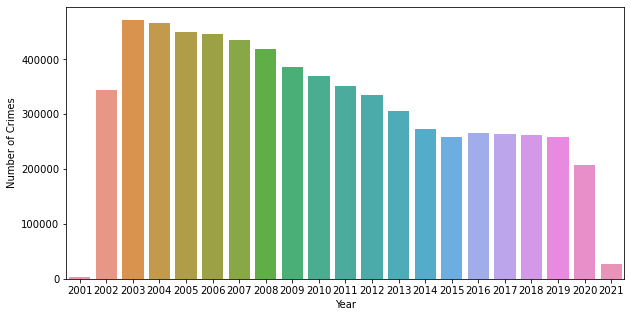

In [27]:
df_plot_year = pd.DataFrame(df['Year'].value_counts()).reset_index()
df_plot_year.columns = ['Year', 'Number of Crimes']

plt.figure(figsize=(10,5))
sns.barplot(y='Number of Crimes', x='Year', data=df_plot_year)

1. 2001 and 2021 like have an insufficient amount of data.
2. There has been a steady decline in the number of cases from 2003 to 2020, which is a good sign.


#### Most dangerous day of the week

<AxesSubplot:xlabel='Day of Week', ylabel='Number of Crimes'>

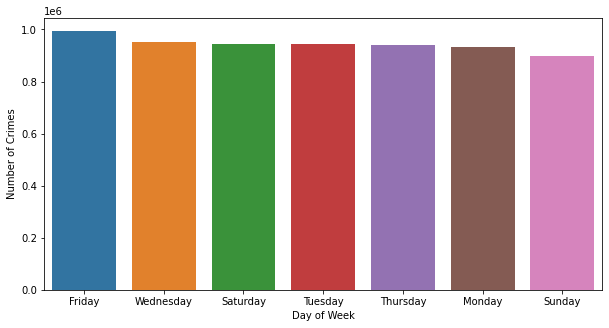

In [12]:
df_plot_dow = pd.DataFrame(df['Day Name'].value_counts()).reset_index()
df_plot_dow.columns = ['Day of Week', 'Number of Crimes']

plt.figure(figsize=(10,5))
sns.barplot(y='Number of Crimes', x='Day of Week', data=df_plot_dow)

Fridays seem to be the most dangerous day of the week. One possible reason may be that it is the day that many people go out to have fun and possibly get intoxicated, thereafter committing crimes.

#### Most dangerous hours

<AxesSubplot:xlabel='Number of Crimes', ylabel='Hour'>

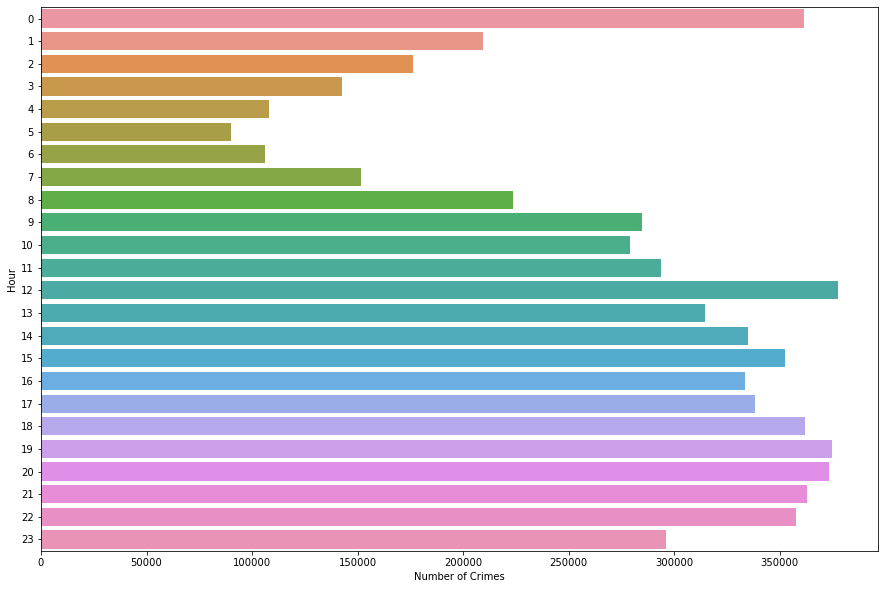

In [13]:
df_plot_hour = pd.DataFrame(df['Hour'].value_counts()).reset_index()
df_plot_hour.columns = ['Hour', 'Number of Crimes']

plt.figure(figsize=(15,10))
sns.barplot(y='Hour', x='Number of Crimes', data=df_plot_hour)

Midnight, noon and evening-night seem to be when more crimes occur. On the other hand, less crimes seem to occur in the late night/early morning hours. 

## Logistic Regression

#### Correcting data types

In [14]:
df_grp['Primary Type'] = pd.factorize(df_grp['Primary Type'])[0]
df_grp = df_grp.astype({'Block': 'category', 'IUCR': 'category', 'Description': 'category', 'Location Description': 'category', 
                'FBI Code': 'category', 'Beat': 'category', 'District': 'category', 'Ward': 'category', 
                'Community Area': 'category', 'Year': 'category', 'Month': 'category', 'Day': 'category', 
                'Day of Week': 'category', 'Hour': 'category', 'Primary Type': 'category', 'Arrest': 'category', 'Domestic': 'category'})

df_grp = df_grp.drop(columns=['Month Name', 'Day Name', 'Day of Week', 'Community Area Name'])

In [15]:
df_grp.head()

,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Month,Day,Hour
0,0,0,0,0,0,False,True,924,9.0,12.0,61.0,0,2015,9,5,13
1,1,1,1,1,1,False,False,1511,15.0,29.0,25.0,1,2015,9,4,11
2,2,2,2,2,2,True,False,1412,14.0,35.0,21.0,2,2015,9,5,12
3,3,3,0,3,3,False,True,1522,15.0,28.0,25.0,3,2015,9,5,13
4,4,4,1,4,0,False,False,614,6.0,21.0,71.0,4,2015,9,5,10


In [16]:
#df_grp_sample = df_grp.sample(frac=0.01, replace=True, random_state=69)

#### Correlation Heatmap

In [17]:
# factorize df so they are int64 to calculate correlation
for col in df_grp.columns:
    df_grp[col] = pd.factorize(df_grp[col])[0]

<AxesSubplot:>

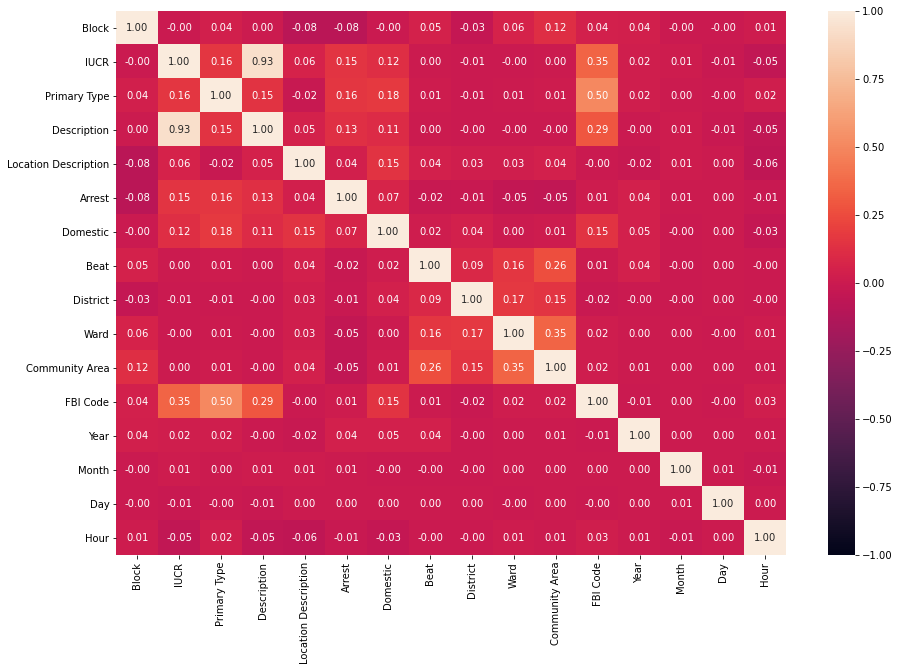

In [18]:
corr = df_grp.corr(method='pearson')
plt.figure(figsize=(15,10))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, fmt='.2f')

We can see that among the independent variables, 'IUCR' has a high correlation coefficient with 'Description'. They have some correlation with 'FBI Code' as well, but the correlation coeffiecient is below our threshold of 0.7. As a result, we will drop 'Description' but keep 'IUCR' and 'FBI Code'.

In [19]:
df_grp = df_grp.drop(columns=['Description'])

In [20]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#### Train-test split

In [21]:
X = df_grp[df_grp.columns.difference(['Primary Type'])]
Y = df_grp["Primary Type"]

# create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=69)

#### Model

In [22]:
logistic = LogisticRegression()

# define grid search
multi_class = ['ovr', 'multinomial']
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(multi_class=multi_class, solver=solvers, penalty=penalty, C=c_values)

logistic_classifier = RandomizedSearchCV(logistic, grid, cv=10, n_iter=10, random_state=69, 
                                         scoring='accuracy', error_score=0, n_jobs=-1)
grid_search = logistic_classifier.fit(X_train, y_train)

# make the predictions
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print("Assumptions:")
print("1. Assumes all variables to be multivariate normal")
print("2. Assumes little or no multicollinearity, variables are not highly correlated with each other")
print("3. Assumes that there is little or no autocorrelation in the data, residuals are independent from each other")
print()
print("Logistic Regression")
print("================================")

# summarize results
print('\x1b[1;31m'+"Using Random Search CV, 10-fold Cross Validation for hyperparameter tuning"+'\x1b[0m')
print("Best Trainset Accuracy: %.2f%% using %s" % (grid_search.best_score_*100, grid_search.best_params_))
print("Testset Accuracy: %.2f%% " % (accuracy_score(y_test, y_test_pred)*100))

C:\Users\chen-\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\chen-\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\chen-\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\chen-\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\chen-\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

Assumptions:
1. Assumes all variables to be multivariate normal
2. Assumes little or no multicollinearity, variables are not highly correlated with each other
3. Assumes that there is little or no autocorrelation in the data, residuals are independent from each other

Logistic Regression
Using Random Search CV, 10-fold Cross Validation for hyperparameter tuning
Best Trainset Accuracy: 53.22% using {'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.1}
Testset Accuracy: 53.19% 


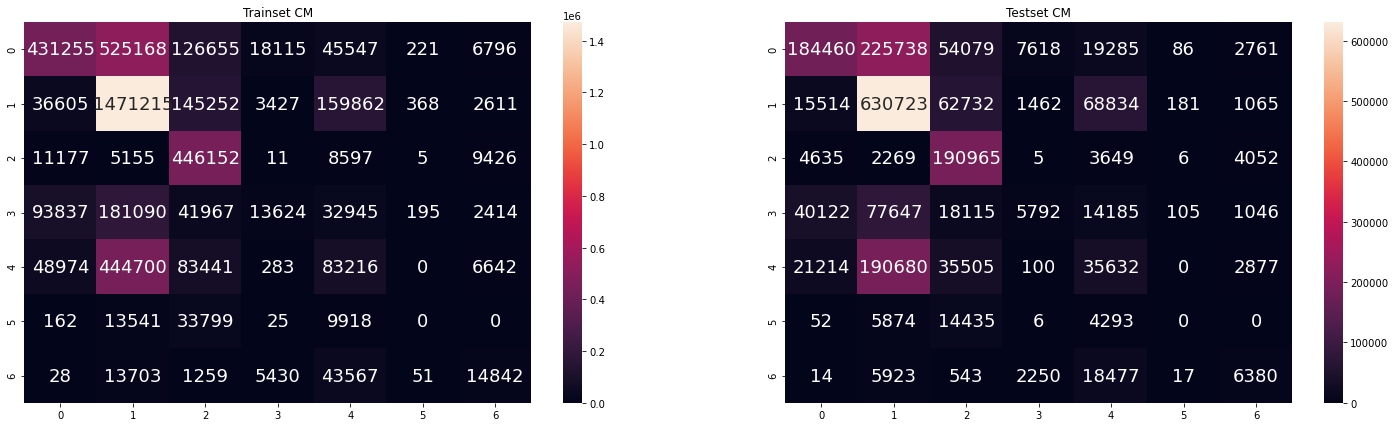

In [23]:
# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(25, 7))
sns.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
axes[0].set_title("Trainset CM")
axes[1].set_title("Testset CM")
plt.show()

In [24]:
print("Trainset Confusion Matrix")
print("=========================")
print(confusion_matrix(y_train, y_train_pred))
print("\n")
print("Testset Confusion Matrix")
print("========================")
print(confusion_matrix(y_test, y_test_pred))

Trainset Confusion Matrix
[[ 431255  525168  126655   18115   45547     221    6796]
 [  36605 1471215  145252    3427  159862     368    2611]
 [  11177    5155  446152      11    8597       5    9426]
 [  93837  181090   41967   13624   32945     195    2414]
 [  48974  444700   83441     283   83216       0    6642]
 [    162   13541   33799      25    9918       0       0]
 [     28   13703    1259    5430   43567      51   14842]]


Testset Confusion Matrix
[[184460 225738  54079   7618  19285     86   2761]
 [ 15514 630723  62732   1462  68834    181   1065]
 [  4635   2269 190965      5   3649      6   4052]
 [ 40122  77647  18115   5792  14185    105   1046]
 [ 21214 190680  35505    100  35632      0   2877]
 [    52   5874  14435      6   4293      0      0]
 [    14   5923    543   2250  18477     17   6380]]


In [25]:
df_results = pd.DataFrame(grid_search.cv_results_)
print("Details of the RandomizedSearchCV results")
df_results

Details of the RandomizedSearchCV results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_penalty,param_multi_class,param_C,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1677.792796,273.569188,1.000115,0.316523,lbfgs,l2,multinomial,10,"{'solver': 'lbfgs', 'penalty': 'l2', 'multi_cl...",0.390433,...,0.390749,0.387360,0.388472,0.387892,0.389318,0.387788,0.393881,0.389259,0.001881,3
1,6.244844,1.224401,0.000000,0.000000,lbfgs,elasticnet,ovr,10,"{'solver': 'lbfgs', 'penalty': 'elasticnet', '...",0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
2,8388.850447,2731.619603,0.569087,0.109901,newton-cg,l2,ovr,0.1,"{'solver': 'newton-cg', 'penalty': 'l2', 'mult...",0.531625,...,0.532433,0.532701,0.531974,0.532180,0.531576,0.532947,0.531896,0.532182,0.000416,1
3,1.787619,0.595727,0.000000,0.000000,liblinear,elasticnet,ovr,0.01,"{'solver': 'liblinear', 'penalty': 'elasticnet...",0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
4,1.526071,0.050896,0.000000,0.000000,lbfgs,elasticnet,multinomial,1.0,"{'solver': 'lbfgs', 'penalty': 'elasticnet', '...",0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
5,1.526417,0.091912,0.000000,0.000000,newton-cg,l1,ovr,0.01,"{'solver': 'newton-cg', 'penalty': 'l1', 'mult...",0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
6,1.574640,0.060660,0.000000,0.000000,lbfgs,l1,multinomial,100,"{'solver': 'lbfgs', 'penalty': 'l1', 'multi_cl...",0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
7,474.224718,19.210696,0.556813,0.148104,lbfgs,l2,multinomial,100,"{'solver': 'lbfgs', 'penalty': 'l2', 'multi_cl...",0.390433,...,0.390775,0.387360,0.389770,0.387639,0.389318,0.388212,0.393875,0.389422,0.001852,2
8,1.666941,0.575686,0.000000,0.000000,liblinear,elasticnet,ovr,100,"{'solver': 'liblinear', 'penalty': 'elasticnet...",0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
9,1.370837,0.055421,0.000000,0.000000,liblinear,elasticnet,ovr,10,"{'solver': 'liblinear', 'penalty': 'elasticnet...",0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
